In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pprint import pprint

# Inverse Kinematics Equations
## calculate the angles from x, y, z coords

In [40]:
def get_angles_5dof(X, Y, Z, P, T, la=1, lb=1, lc=1, ld=1):
    X1 = np.array([X - ld * np.sin(T)*np.cos(P),
                   Y - ld * np.cos(T),
                   Z - ld * np.sin(T)*np.sin(P)]).transpose((1,0))

    thd = np.arctan2(X1[:,2], X1[:,0])
    the = P - thd

    m = np.sqrt(lc**2 - (lc*np.cos(T))**2)

    X2 = np.array([X1[:,0] - m * np.cos(thd),
                   X1[:,1] - lc * np.cos(T),
                   X1[:,2] - m * np.sin(thd)]).transpose((1,0))

    R = np.sqrt(X2[:,0]**2 + X2[:,2]**2)

    theta = np.arctan2(R, X1[:,1])
    r = np.sqrt(R**2 + X2[:,1]**2)

    beta = np.arccos((r**2+la**2-lb**2)/(2*r*la))
    gamma = np.arccos((lb**2 + la**2 - r**2)/(2*lb*la))

    tha = theta-beta
    thb = np.pi - gamma
    thc = T - tha - thb

    return tha, thb, thc, thd, the


i = np.linspace()
X, Y, Z = np.linspace(-1, 1, 20), np.zeros(20)+1, np.zeros(20) - 1
P = T = np.zeros(20)

tha, thb, thc, thd, the = get_angles_5dof(X,Y,Z,P,T)
the = np.zeros(20)

# 3D Forward Kinematics

In [70]:
def arm_coords_5dof(tha, thb, thc, thd, the, la=1, lb=1, lc=1, ld=1):

    # get the incremental coordinates from the angles
    T = tha + thb + thc
    y_points = np.array([np.zeros(len(tha)),
                         la*np.cos(tha),
                         lb*np.cos(tha+thb),
                         lc*np.cos(T),
                         ld*np.cos(T)*np.cos(the)]).transpose((1,0))

    x_points = np.array([np.zeros(len(tha)),
                         la*np.sin(tha)*np.cos(thd),
                         lb*np.sin(tha+thb)*np.cos(thd),
                         lc*np.sin(T)*np.cos(thd),
                         ld*np.sin(T)*np.cos(thd)*np.cos(the) - ld*np.sin(the)*np.sin(thd)]).transpose((1,0))

    z_points = np.array([np.zeros(len(tha)),
                         la*np.sin(tha)*np.sin(thd),
                         lb*np.sin(tha+thb)*np.sin(thd),
                         lc*np.sin(T)*np.sin(thd),
                         ld*np.sin(T)*np.sin(thd)*np.cos(the) + ld*np.sin(the)*np.cos(thd)]).transpose((1,0))

    # get the absolute coordinates from the incremental coords
    x_points = np.cumsum(x_points, axis=1)
    y_points = np.cumsum(y_points, axis=1)
    z_points = np.cumsum(z_points, axis=1)


    return x_points, y_points, z_points


x_points, y_points, z_points = arm_coords_5dof(tha, thb, thc, thd, the)
x_points.shape

In [79]:
def arm_coords_vect(th1, th2, th3, phi1, phi2,r1=1, r2=1, r3=1):
    # get change in cartesean position caused by each arm
    dX1 = np.array([r1 * np.sin(th1) * np.cos(phi1),
                    r1 * np.sin(th1) * np.sin(phi1),
                    r1 * np.cos(th1)]).transpose(1, 0)

    dX2 = np.array([r2 * np.sin(th1 + th2) * np.sin(phi1),
                    r2 * np.sin(th1 + th2) * np.cos(phi1),
                    r2 * np.cos(th1 + th2)]).transpose(1, 0)

    dX3 = np.array([r3 * (np.sin(phi1)*np.sin(phi2)*np.sin(th3)*np.cos(th1+th2) + np.sin(phi1)*np.sin(th1+th2)*np.cos(th3) + np.sin(th3)*np.cos(phi1)*np.cos(phi2)),
                    r3 * (-np.sin(phi1)*np.sin(th3)*np.cos(phi2) + np.sin(phi2)*np.sin(th3)*np.cos(phi1)*np.cos(th1+th2) + np.sin(th1+th2)*np.cos(phi1)*np.cos(th3)),
                    r3 * (-np.sin(phi2)*np.sin(th3)*np.sin(th1+th2) + np.cos(th3)*np.cos(th1+th2))]).transpose(1, 0)
    # get absolute position from incremental positions
    X1 = dX1
    X2 = X1 + dX2
    X3 = X2 + dX3
    # format output for animation
    x_points = np.array([np.zeros(len(th1)),
                         X1[:, 0],
                         X2[:, 0],
                         X3[:, 0]]).transpose(1, 0)

    y_points = np.array([np.zeros(len(th1)),
                         X1[:, 1],
                         X2[:, 1],
                         X3[:, 1]]).transpose(1, 0)

    z_points = np.array([np.zeros(len(th1)),
                         X1[:, 2],
                         X2[:, 2],
                         X3[:, 2]]).transpose(1, 0)
    return x_points, y_points, z_points

phi1 = phi2 = np.zeros(20)
th1 = th2 = th3 = np.linspace(0, np.pi/3, 20)

x_points, y_points, z_points = arm_coords_vect(th1, th2, th3, phi1, phi2)

# Animation

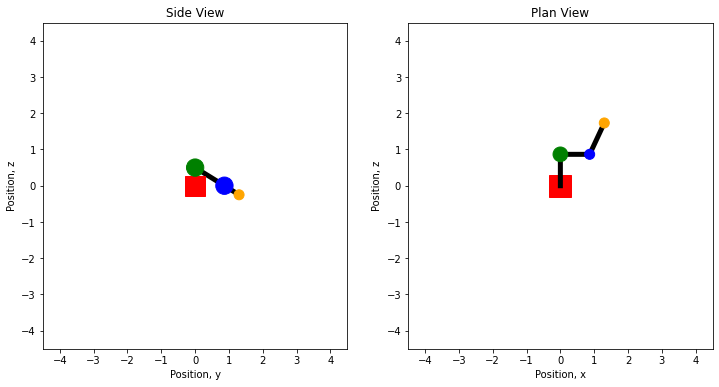

In [86]:
def animate_5dof(x_points, y_points, z_points, thAs=None, thBs=None, thCs=None):
    if not (thAs is None or thBs is None or thCs is None):
        big_plot = True
        thAs, thBs, thCs = thAs*180/np.pi, thBs*180/np.pi, thCs*180/np.pi
    else:
        big_plot=False

    # get bounds for marker sizes
    size_bounds_x = [np.min(np.min(x_points, axis=1)), np.max(np.max(x_points, axis=1))]
    size_bounds_z = [np.min(np.min(z_points, axis=1)), np.max(np.max(z_points, axis=1))]
    size_bounds_y = [np.min(np.min(y_points, axis=1)), np.max(np.max(y_points, axis=1))]


    # the animation
    if big_plot:
        fig = plt.figure(figsize=(12, 12))
        ax1 = plt.subplot(2,2,1)
        ax2 = plt.subplot(2,2,2)
        ax3 = plt.subplot(2,1,2)

        ax3.set_xlim([0, len(thAs)])
        ax3.set_ylim([np.min([np.min(thCs), np.min(thAs), np.min(thBs)]), np.max([np.max(thCs), np.max(thAs), np.max(thBs)])])
        ax3.plot(thAs[:1], label="$\\theta_a$")
        ax3.plot(thBs[:1], label="$\\theta_b$")
        ax3.plot(thCs[:1], label="$\\theta_c$")
        ax3.legend()
        ax3.set_title("Motor Angles")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Motor Angle (degrees)")
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def construct_frame(i):
        xpoints = x_points[i,:]
        ypoints = y_points[i,:]
        zpoints = z_points[i,:]

        # Side on view of the robot
        ax1.clear()
        ax1.set_xlim([-4.5, 4.5])
        ax1.set_ylim([-4.5, 4.5])
        ax1.plot(ypoints, zpoints, linewidth=5, color="black", zorder=1)
        ax1.plot(0, 0, 's', markersize=20, color="red", zorder=2)
        ax1.scatter(x=ypoints[1:], y=zpoints[1:], s=np.interp(xpoints[1:], size_bounds_x, [500, 100]), c=["green", "blue", "orange"], zorder=3)
        ax1.set_xlabel("Position, y")
        ax1.set_ylabel("Position, z")
        ax1.set_title("Side View")

        # top down view of the robot
        ax2.clear()
        ax2.set_xlim([-4.5, 4.5])
        ax2.set_ylim([-4.5, 4.5])
        ax2.plot(ypoints, xpoints, linewidth=5, color="black", zorder=2)
        ax2.plot(0, 0, marker=(4, 0, 45-(180/np.pi)*np.arctan2(ypoints[1], xpoints[1])), markersize=30, color="red", zorder=1)
        ax2.scatter(x=ypoints[1:], y=xpoints[1:], s=np.interp(zpoints[1:], size_bounds_y, [100, 500]), c=["green", "blue", "orange"], zorder=3)
        ax2.set_title("Plan View")
        ax2.set_xlabel("Position, x")
        ax2.set_ylabel("Position, z")

        if big_plot:
            # log of motor positions
            ax3.plot(thAs[:i], label="$\\theta_a$", color="blue")
            ax3.plot(thBs[:i], label="$\\theta_b$", color="orange")
            ax3.plot(thCs[:i], label="$\\theta_c$", color="green")

    # set ani variable to call the
    # function recursively
    anim = FuncAnimation(fig, construct_frame, interval=1, frames=len(x_points[:,1]))
    anim.save("out.mp4", fps=24, dpi=200)

animate_5dof(x_points, y_points, z_points)